In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns


print("Ячейка 1: Загрузка 'чистых' данных...")
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

#  PassengerId для файла отправки
test_passenger_ids = test_df['PassengerId']

print(f"Размер Train: {train_df.shape}")
print(f"Размер Test: {test_df.shape}")

Ячейка 1: Загрузка 'чистых' данных...
Размер Train: (891, 12)
Размер Test: (418, 11)



Ячейка 2: Запуск EDA...


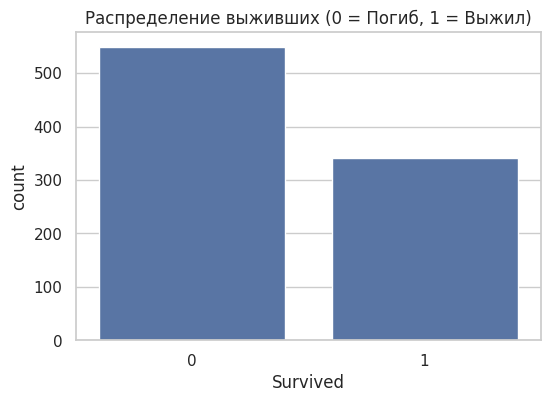

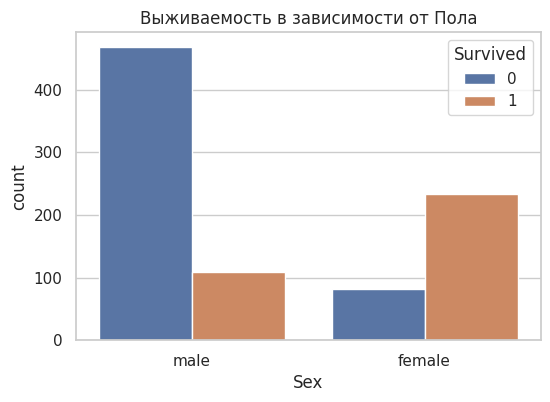

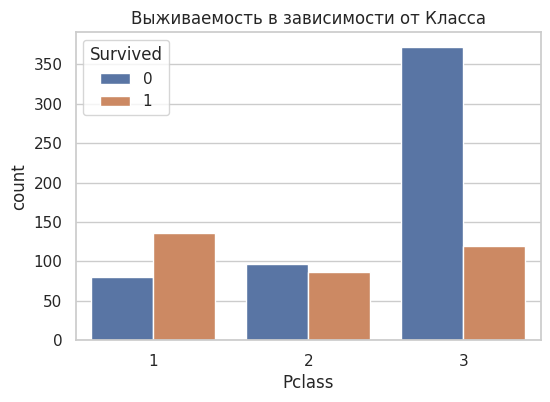

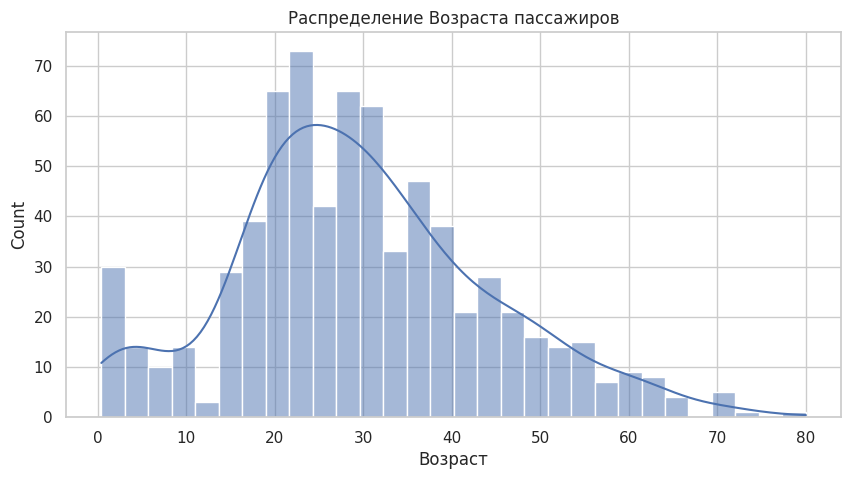

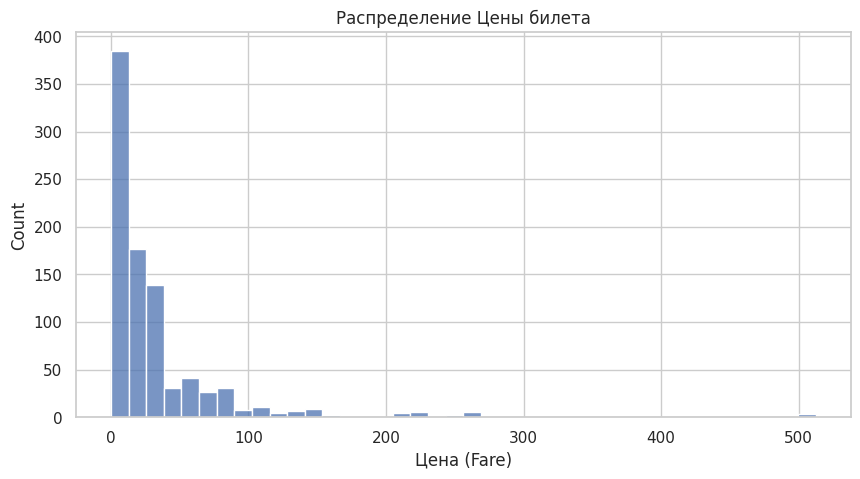

In [7]:
# Визуализация (EDA) 
print("\nЯчейка 2: Запуск EDA...")

# Настроим стиль графиков
sns.set(style="whitegrid")

# 1. Целевая переменная: Сколько выжило? ---
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=train_df)
plt.title('Распределение выживших (0 = Погиб, 1 = Выжил)')
plt.show()

# --- 2. Гипотеза: "Женщины и дети вперед" (Sex) ---
# Это самая важная визуализация в "Титанике"
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', hue='Survived', data=train_df)
plt.title('Выживаемость в зависимости от Пола')
plt.show()


# --- 3. Гипотеза: "Богатые выживают" (Pclass) ---
plt.figure(figsize=(6, 4))
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title('Выживаемость в зависимости от Класса')
plt.show()


# --- 4. Распределение Возраста (Age) ---
# Мы видим много пропусков (NaN), histplot их игнорирует
plt.figure(figsize=(10, 5))
sns.histplot(train_df['Age'].dropna(), kde=True, bins=30)
plt.title('Распределение Возраста пассажиров')
plt.xlabel('Возраст')
plt.show()


# --- 5. Распределение Цены (Fare) ---
plt.figure(figsize=(10, 5))
sns.histplot(train_df['Fare'], kde=False, bins=40)
plt.title('Распределение Цены билета')
plt.xlabel('Цена (Fare)')
plt.show()

In [8]:
# --- ЕДИНЫЙ БЛОК ПРЕДОБРАБОТКИ (Гипотезы 1-5) ---
print("\nЯчейка 2: Запуск ЕДИНОГО блока предобработки...")

# -- Создаем копии, чтобы избежать "SettingWithCopyWarning"
# Мы работаем с train_data и test_data
train_data = train_df.copy()
test_data = test_df.copy()

# --- ГИПОТЕЗА 1: Фича "Title" (Титул) ---
print("Создание 'Title'...")
# Шаг 1: Извлечение
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# Шаг 2: Очистка
train_data['Title'] = train_data['Title'].replace(['Mlle', 'Ms'], 'Miss')
train_data['Title'] = train_data['Title'].replace('Mme', 'Mrs')
test_data['Title'] = test_data['Title'].replace(['Mlle', 'Ms'], 'Miss')
test_data['Title'] = test_data['Title'].replace('Mme', 'Mrs')
rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Don', 'Lady', 'Sir', 'Capt', 'Countess', 'Jonkheer', 'Dona']
train_data['Title'] = train_data['Title'].replace(rare_titles, 'Rare')
test_data['Title'] = test_data['Title'].replace(rare_titles, 'Rare')
# Заполняем 1 пропуск в test_data (если вдруг появился)
test_data['Title'] = test_data['Title'].fillna('Rare')


# ГИПОТЕЗА 2 и 3: "FamilySize" и "IsAlone"
print("Создание 'FamilySize' и 'IsAlone'...")
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)

# ГИПОТЕЗА 4: "Deck" (Палуба)
print("Создание 'Deck'...")
train_data['Deck'] = train_data['Cabin'].fillna('U').str[0]
test_data['Deck'] = test_data['Cabin'].fillna('U').str[0]

# ГИПОТЕЗА 5: Заполнение пропусков (Age, Fare, Embarked)
print("Заполнение пропусков в 'Age', 'Fare', 'Embarked'...")
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])

# УДАЛЕНИЕ "МУСОРНЫХ" КОЛОНОК (ДО кодирования)

drop_cols = ['Name', 'Ticket', 'Cabin', 'PassengerId']
train_data = train_data.drop(columns=drop_cols)
test_data = test_data.drop(columns=drop_cols)

# Кодирование (One-Hot Encoding)
print("Финальное кодирование (get_dummies)...")
categorical_features = ['Title', 'Deck', 'Sex', 'Embarked']
# Мы используем pd.concat, чтобы "взорвать" ОБА датасета ОДИНАКОВО
full_data = pd.concat([train_data, test_data], axis=0)
full_data_dummies = pd.get_dummies(full_data, columns=categorical_features, drop_first=True)

# Разделяем обратно
X_train = full_data_dummies.iloc[:len(train_data)]
X_test = full_data_dummies.iloc[len(train_data):]
y_train = train_data['Survived'] # Берем 'Survived' из train_data (до "взрыва")

# УДАЛЯЕМ 'Survived' из X_train
X_train = X_train.drop('Survived', axis=1)
X_test = X_test.drop('Survived', axis=1)

print("\n--- ПРЕДОБРАБОТКА ЗАВЕРШЕНА ---")
print("Колонки в X_train:", X_train.shape)
print("Колонки в X_test:", X_test.shape)
print("Колонки в y_train:", y_train.shape)


Ячейка 2: Запуск ЕДИНОГО блока предобработки...
Создание 'Title'...
Создание 'FamilySize' и 'IsAlone'...
Создание 'Deck'...
Заполнение пропусков в 'Age', 'Fare', 'Embarked'...
Финальное кодирование (get_dummies)...

--- ПРЕДОБРАБОТКА ЗАВЕРШЕНА ---
Колонки в X_train: (891, 22)
Колонки в X_test: (418, 22)
Колонки в y_train: (891,)


In [9]:
from sklearn.linear_model import LogisticRegression  # <-- ВОЗВРАЩАЕМ НАШУ ПЕРВУЮ МОДЕЛЬ
from sklearn.preprocessing import StandardScaler

# --- Ячейка 3: Обучение Модели (LogisticRegression) и Отправка ---
print("\nЯчейка 3: Запуск обучения (Logistic Regression)...")

# --- ШАГ 1: Масштабирование (StandardScaler) ---
# Это КРИТИЧЕСКИ ВАЖНО для LogisticRegression!
scaler = StandardScaler()
# Мы "обучаем" scaler на X_train и СРАЗУ ЖЕ трансформируем X_train
X_train_scaled = scaler.fit_transform(X_train)
# Мы "трансформируем" X_test, используя "знания" (mean/std) от X_train
X_test_scaled = scaler.transform(X_test)

print("Данные отмасштабированы (StandardScaler).")

# --- ШАГ 2: Обучение "Умной" LogisticRegression ---
# Мы "кормим" нашу "простую" модель нашими "умными" фичами
model = LogisticRegression(max_iter=1000, random_state=42)

model.fit(X_train_scaled, y_train)
print("Модель LogisticRegression ОБУЧЕНА на 'умных' фичах!")

# --- ШАГ 3: Создание файла для Kaggle ---
predictions = model.predict(X_test_scaled).astype(int)

submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predictions
})

# Сохраняем финальный файл
submission.to_csv('submission_FINAL_LogReg.csv', index=False)
print("\n--- ФИНАЛЬНЫЙ ФАЙЛ 'submission_FINAL_LogReg.csv' СОЗДАН! ---")
submission.head()


Ячейка 3: Запуск обучения (Logistic Regression)...
Данные отмасштабированы (StandardScaler).
Модель LogisticRegression ОБУЧЕНА на 'умных' фичах!

--- ФИНАЛЬНЫЙ ФАЙЛ 'submission_FINAL_LogReg.csv' СОЗДАН! ---


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1



Ячейка 5: Визуализация 'Важности фичей' (Весов)...


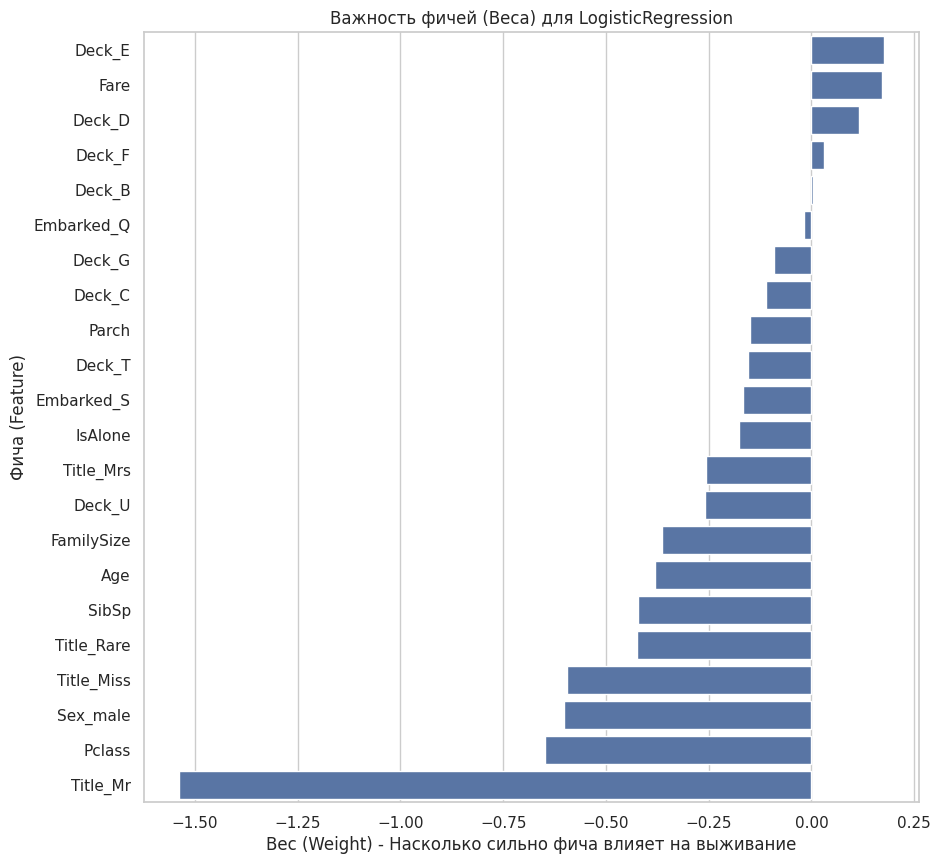

In [10]:
# --- Ячейка 5: Визуализация "Мозгов" LogisticRegression ---
print("\nЯчейка 5: Визуализация 'Важности фичей' (Весов)...")

# 'model' - это обученная LogisticRegression из Ячейки 4
# 'X_train' - это DataFrame ДО масштабирования из Ячейки 3

# --- 1. Получаем "веса" ---
# model.coef_ - это 2D-массив, нам нужен 1D (поэтому [0])
weights = model.coef_[0]

# --- 2. Получаем "имена фичей" ---
# Имена фичей хранятся в X_train (до масштабирования)
feature_names = X_train.columns

# --- 3. Создаем DataFrame для удобства ---
# 'Фича': Pclass, 'Вес': -0.5
# 'Фича': Sex_male, 'Вес': -2.1
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Weight': weights})

# --- 4. Сортируем по "весу", чтобы график был красивым ---
# Мы используем abs(Weight), чтобы увидеть САМЫЕ ВАЖНЫЕ (и плохие, и хорошие)
feature_importance_df = feature_importance_df.sort_values(by='Weight', ascending=False)

# --- 5. Строим график ---
plt.figure(figsize=(10, 10)) # Делаем график высоким, т.к. фичей много
sns.barplot(x='Weight', y='Feature', data=feature_importance_df)
plt.title('Важность фичей (Веса) для LogisticRegression')
plt.xlabel('Вес (Weight) - Насколько сильно фича влияет на выживание')
plt.ylabel('Фича (Feature)')
plt.show()